In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import random
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# Model evaluation

In [ ]:
#Read dataset
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

#add location to each sample
train_a["location"] = "A"
train_b["location"] = "B"
train_c["location"] = "C"
X_train_estimated_a["location"] = "A"
X_train_estimated_b["location"] = "B"
X_train_estimated_c["location"] = "C"
X_train_observed_a["location"] = "A"
X_train_observed_b["location"] = "B"
X_train_observed_c["location"] = "C"

#remove extra minute 00 sample
X_train_observed_a = X_train_observed_a.iloc[:-1,:]
X_train_observed_b = X_train_observed_b.iloc[:-1,:]
X_train_observed_c = X_train_observed_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_train_observed_a.insert(0, "date_calc", X_train_observed_a["date_forecast"])
X_train_observed_b.insert(0, "date_calc", X_train_observed_b["date_forecast"])
X_train_observed_c.insert(0, "date_calc", X_train_observed_c["date_forecast"])

#concat all the samples and remove date_calc column
X_train_raw = pd.concat([X_train_observed_a,
                     X_train_observed_b,
                     X_train_observed_c,
                     X_train_estimated_a,
                     X_train_estimated_b,
                     X_train_estimated_c])

#remove some weird artifacts from train_b target values
train_b = pd.concat([train_b[:18690], train_b[20142:]])
train_b["rolling"] = train_b["pv_measurement"].rolling(4).mean()
train_b["keep"] = train_b["pv_measurement"] - train_b["rolling"] != 0 + train_b["pv_measurement"].apply(lambda a: a==0)
train_b = train_b[train_b["keep"]]
train_b = train_b.iloc[:,:3]

targets = pd.concat([train_a,
                     train_b,
                     train_c]).dropna()

#X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes=-60)

features00 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 0)].copy()
features00["merge_time"] = features00["date_forecast"]


features15 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 15)].copy()
features15["merge_time"] = features15["date_forecast"] + pd.Timedelta(minutes=-15)


features30 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 30)].copy()
features30["merge_time"] = features30["date_forecast"] + pd.Timedelta(minutes=-30)


features45 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 45)].copy()
features45["merge_time"] = features45["date_forecast"] + pd.Timedelta(minutes=-45)


X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes = -60)
features60 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 00)].copy()
features60["merge_time"] = features60["date_forecast"]

dataset = targets
dataset = dataset.rename(columns={"time": "merge_time"})

#averages the features meassured at target time +00, +15, +30, +45 and +60
def add_feature_average_00_60(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = pd.merge(
        left=dataset,
        right = f00[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")
    dataset = pd.merge(
        left=dataset,
        right = f15[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_15"])
    dataset = pd.merge(
        left=dataset,
        right = f30[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_30"])
    dataset = pd.merge(
        left=dataset,
        right = f45[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_45"])
    dataset = pd.merge(
        left=dataset,
        right = f60[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_60"])


    dataset[column_name] = (dataset[column_name] +
                            dataset[column_name + "_15"] +
                            dataset[column_name + "_30"] +
                            dataset[column_name + "_45"] +
                            dataset[column_name + "_60"])/5
    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

#adds a single feature from one observation
def add_feature(dataset, f, column_name):
  return pd.merge(
        left=dataset,
        right=f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner"
  )

#adds an One Hot Encoding of the column to the dataset
def OHE(dataset, f, column_name, suffix=""):

    dataset = pd.merge(
        left=dataset,
        right = f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")

    values = dataset[column_name].unique()

    for value in values:
        dataset[column_name + "_" + suffix + str(value)] = dataset[column_name].apply(lambda a : a == value).map({True: 1, False: 0})

    dataset = dataset.drop([column_name], axis=1)
    return dataset

def OHE_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = OHE(dataset, f00, column_name, suffix="00_")
    dataset = OHE(dataset, f15, column_name, suffix="15_")
    dataset = OHE(dataset, f30, column_name, suffix="30_")
    dataset = OHE(dataset, f45, column_name, suffix="45_")
    dataset = OHE(dataset, f60, column_name, suffix="60_")

    return dataset

#adds all observations
def add_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset[column_name + "_00"] = add_feature(dataset, f00, column_name)[column_name]
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    return dataset

#gjennomsnitt fordi verdien er trolig momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "absolute_humidity_2m:gm3")

#gjennomsnitt fordi verdien er trolig momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "air_density_2m:kgm3")

#tar verdien fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "clear_sky_energy_1h:J")

#gjennomsnitt fordi verdien er momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "clear_sky_rad:W")

#OHE av kategorisk variabel #!Opp til diskusjon om man skal ta gjennomsnitt eller flere av målingene
dataset = OHE(dataset, features60, "dew_or_rime:idx")

#gjennomsnitt fordi verdien er trolig momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "dew_point_2m:K")

#gjennomsnitt fordi verdien er momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "diffuse_rad:W")

#tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "diffuse_rad_1h:J")

#gjennomsnitt fordi verdien er momentan
dataset = add_feature(dataset, features60, "direct_rad:W")#!Try without

#tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "direct_rad_1h:J")#!Try without

#gjennomsnitt fordi verdien er trolig momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "effective_cloud_cover:p")

#tar verdi fra +60 siden den viser måling mellom 00 og 60, #!kan det være gunstig å ha med 3h, 6h, 12h, 24h????
dataset = add_feature(dataset, features60, "fresh_snow_1h:cm")

#tar alle verdiene siden disse nok er ekstremt viktige for modellen
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_day:idx")

#tar alle verdiene siden disse nok er ekstremt viktige for modellen
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_in_shadow:idx")

#tar gjennomsnittet siden jeg vet ikke +++ #!jeg tar kun med en type måling for trykk, raw data inneholder 4 forskjellige mulig at flere er relevante
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "msl_pressure:hPa")

#tar alle verdier siden måleintervallet er så kort
dataset = add_all(dataset, features00, features15, features30, features45, features60, "precip_5min:mm")
dataset = OHE(dataset, features00, "precip_type_5min:idx")

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "prob_rime:p")

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "relative_humidity_1000hPa:p")

#OHE because value is binary
dataset = OHE(dataset, features60, "snow_density:kgm3")

#disse tar jeg bare gjennomsnittet av
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_depth:cm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_drift:idx")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_melt_10min:mm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_water:kgm2")

#legger til alle siden har testing har vist at disse er svært viktige
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_azimuth:d")
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_elevation:d")

#gjennomsnitt siden variasjonen hvert kvarter sannsynligvis
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "t_1000hPa:K")

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "total_cloud_cover:p")

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "visibility:m")

#Gjennomsnitt fordi lite variabel
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_u_10m:ms")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_v_10m:ms")

#OHE av location
dataset["location_A"] = dataset["location"].apply(lambda loc: loc == "A").map({True: 1, False: 0})
dataset["location_B"] = dataset["location"].apply(lambda loc: loc == "B").map({True: 1, False: 0})
dataset["location_C"] = dataset["location"].apply(lambda loc: loc == "C").map({True: 1, False: 0})

#dataset["day"] = dataset["merge_time"].apply(lambda a : a.day_of_year)
#dataset["hour"] = dataset["merge_time"].apply(lambda a : a.hour)

display(dataset)

# Normalizing and transforming features

In [ ]:
dataset["absolute_humidity_2m:gm3"] = dataset["absolute_humidity_2m:gm3"]/dataset["absolute_humidity_2m:gm3"].std()
dataset["clear_sky_energy_1h:J"] = dataset["clear_sky_energy_1h:J"]/dataset["clear_sky_energy_1h:J"].std()
dataset["clear_sky_rad:W"] = dataset["clear_sky_rad:W"]/dataset["clear_sky_rad:W"].std()
dataset["dew_point_2m:K"] = (dataset["dew_point_2m:K"]-dataset["dew_point_2m:K"].min())/dataset["dew_point_2m:K"].std()
dataset["diffuse_rad:W"] = dataset["diffuse_rad:W"]/dataset["diffuse_rad:W"].std()
dataset["diffuse_rad_1h:J"] = dataset["diffuse_rad_1h:J"]/dataset["diffuse_rad_1h:J"].std()
dataset["direct_rad:W"] = dataset["direct_rad:W"]/dataset["direct_rad:W"].std()
dataset["direct_rad_1h:J"] = dataset["direct_rad_1h:J"]/dataset["direct_rad_1h:J"].std()
dataset["effective_cloud_cover:p"] = dataset["effective_cloud_cover:p"]/dataset["effective_cloud_cover:p"].std()
dataset["msl_pressure:hPa"] = (dataset["msl_pressure:hPa"]-dataset["msl_pressure:hPa"].min())/dataset["msl_pressure:hPa"].std()
dataset["prob_rime:p"] = dataset["prob_rime:p"]/dataset["prob_rime:p"].std()
dataset["relative_humidity_1000hPa:p"] = (dataset["relative_humidity_1000hPa:p"])/dataset["relative_humidity_1000hPa:p"].std()



#The sun angle features are transformed to represent how much sunlight will hit a flat surface
#This seems like a more relevant number to pass into the model
#K-fold cross validation also seems to agree with this hypothesis
dataset["sun_azimuth:d_00"] = dataset["sun_azimuth:d_00"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_00"] = dataset["sun_azimuth:d_00"]/dataset["sun_azimuth:d_00"].std()
dataset["sun_azimuth:d_15"] = dataset["sun_azimuth:d_15"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_15"] = dataset["sun_azimuth:d_15"]/dataset["sun_azimuth:d_15"].std()
dataset["sun_azimuth:d_30"] = dataset["sun_azimuth:d_30"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_30"] = dataset["sun_azimuth:d_30"]/dataset["sun_azimuth:d_30"].std()
dataset["sun_azimuth:d_45"] = dataset["sun_azimuth:d_45"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_45"] = dataset["sun_azimuth:d_45"]/dataset["sun_azimuth:d_45"].std()
dataset["sun_azimuth:d_60"] = dataset["sun_azimuth:d_60"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_60"] = dataset["sun_azimuth:d_60"]/dataset["sun_azimuth:d_60"].std()

dataset["sun_elevation:d_00"] = dataset["sun_elevation:d_00"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_00"] = dataset["sun_elevation:d_00"]/dataset["sun_elevation:d_00"].std()
dataset["sun_elevation:d_15"] = dataset["sun_elevation:d_15"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_15"] = dataset["sun_elevation:d_15"]/dataset["sun_elevation:d_15"].std()
dataset["sun_elevation:d_30"] = dataset["sun_elevation:d_30"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_30"] = dataset["sun_elevation:d_30"]/dataset["sun_elevation:d_30"].std()
dataset["sun_elevation:d_45"] = dataset["sun_elevation:d_45"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_45"] = dataset["sun_elevation:d_45"]/dataset["sun_elevation:d_45"].std()
dataset["sun_elevation:d_60"] = dataset["sun_elevation:d_60"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_60"] = dataset["sun_elevation:d_60"]/dataset["sun_elevation:d_60"].std()

dataset["t_1000hPa:K"] = (dataset["t_1000hPa:K"]-dataset["t_1000hPa:K"].min())/dataset["t_1000hPa:K"].std()
dataset["total_cloud_cover:p"] = dataset["total_cloud_cover:p"]/dataset["total_cloud_cover:p"].std()
dataset["visibility:m"] = dataset["visibility:m"]/dataset["visibility:m"].std()
dataset["wind_speed_u_10m:ms"] = dataset["wind_speed_u_10m:ms"]/dataset["wind_speed_u_10m:ms"].std()
dataset["wind_speed_v_10m:ms"] = dataset["wind_speed_v_10m:ms"]/dataset["wind_speed_v_10m:ms"].std()
#dataset["day"] = 10*dataset["day"]/dataset["day"].std()
#dataset["hour"] = dataset["hour"]/dataset["hour"].std()



In [ ]:
dataset = dataset.sort_values(by="merge_time")

datasetX = dataset.iloc[:, 3:]
datasetY = dataset.iloc[:, 1]

display(datasetX)
display(datasetY)

Underneath you can see our implementation of k-fold cross evaluation. Most of the hyperparameters(activation, initializers, ) in the model were tweaked using this evaluation

In [ ]:
#!ReWrite
def evaluate_models(models, X, Y):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X)


    preds = preds.iloc[:,1:]


    preds["final"] = preds.mean(axis=1)
    preds["losses"] = (preds["final"] - Y).apply(lambda a : np.abs(a))
    return preds["losses"].mean()


num_folds = 9

losses = []
models = []

for f in range(0, num_folds):
  evalIndex=f*10000
  evalSize=10000

  #partition into training and evalset
  trainsetX = pd.concat([datasetX.iloc[:evalIndex,:],datasetX.iloc[evalIndex+evalSize:,:]])
  trainsetY = pd.concat([datasetY.iloc[:evalIndex],datasetY.iloc[evalIndex+evalSize:]])
  evalsetX = datasetX.iloc[evalIndex:evalIndex+evalSize,:]
  evalsetY = datasetY.iloc[evalIndex:evalIndex+evalSize]

  numModels = 16

  models = []



  i = 0
  while(i < numModels):
    if(i < 8):
      models.append(tf.keras.models.Sequential([
            #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
            tf.keras.layers.Dense(50, activation="tanh",
              kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(50, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal()),
            tf.keras.layers.Dense(1, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal()),
        ]))
    else:
      models.append(tf.keras.models.Sequential([
            #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
            tf.keras.layers.Dense(60, activation="tanh",
              kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(50, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(40, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(30, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(10, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(1, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
        ]))
    models[i].compile(
        optimizer=tf.keras.optimizers.experimental.Adadelta(learning_rate=1,
                                                            #weight_decay=0.0001
                                                            ),
        loss="mean_absolute_error"
    )

    history = models[i].fit(
                        x = trainsetX.sample(frac=0.8 if i < 8 else 0.8, random_state=i),
                        y = trainsetY.sample(frac=0.8 if i < 8 else 0.8, random_state=i),
                        batch_size = 1000,
                        epochs = 1,
                        verbose = 0,
                        #validation_data = [evalsetX, evalsetY]
                    )

    #retry if model is nonsensical
    loss = models[i].evaluate(evalsetX, evalsetY, verbose=0)
    if(loss < evalsetY.mean() + 4 and loss > evalsetY.mean() - 4):
      print("discarding")
      del models[i]
      continue

    history = models[i].fit(
                        x = trainsetX.sample(frac=0.65 if i < 8 else 0.65, random_state=i),
                        y = trainsetY.sample(frac=0.65 if i < 8 else 0.65, random_state=i),
                        batch_size = 1000,
                        epochs = 40,
                        verbose = 0,
                        validation_data = [evalsetX, evalsetY]
                    )
    loss = models[i].evaluate(evalsetX, evalsetY)
    print(i, " complete")
    i+=1

  loss = evaluate_models(models, evalsetX, evalsetY)
  print(loss)
  losses.append(loss)

print(losses)



In [ ]:
def loss(true, indexFirst, indexLast, modelName):
    return (true[indexFirst:indexLast]-modelName[indexFirst:indexLast]).apply(lambda a : abs(a)).mean()

# Ensamble2 predictions for last fold

In [2]:

#Read dataset
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

#add location to each sample
train_a["location"] = "A"
train_b["location"] = "B"
train_c["location"] = "C"
X_train_estimated_a["location"] = "A"
X_train_estimated_b["location"] = "B"
X_train_estimated_c["location"] = "C"
X_train_observed_a["location"] = "A"
X_train_observed_b["location"] = "B"
X_train_observed_c["location"] = "C"

#remove extra minute 00 sample
X_train_observed_a = X_train_observed_a.iloc[:-1,:]
X_train_observed_b = X_train_observed_b.iloc[:-1,:]
X_train_observed_c = X_train_observed_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_train_observed_a.insert(0, "date_calc", X_train_observed_a["date_forecast"])
X_train_observed_b.insert(0, "date_calc", X_train_observed_b["date_forecast"])
X_train_observed_c.insert(0, "date_calc", X_train_observed_c["date_forecast"])

#concat all the samples and remove date_calc column
X_train_raw = pd.concat([X_train_observed_a,
                     X_train_observed_b,
                     X_train_observed_c,
                     X_train_estimated_a,
                     X_train_estimated_b,
                     X_train_estimated_c])

#feature indicating time between date_calc and date_forecast
X_train_raw["calc_time"] =(X_train_raw["date_forecast"] - X_train_raw["date_calc"]).astype('timedelta64[s]')

#fill nans
X_train_raw["snow_density:kgm3"] = X_train_raw["snow_density:kgm3"].apply(
    lambda a : np.isnan(a)
    ).map({True: 0, False: 1})
X_train_raw["ceiling_height_agl:m"] = X_train_raw["ceiling_height_agl:m"].apply(
    lambda a : -1000 if np.isnan(a) else a
)
X_train_raw["cloud_base_agl:m"] = X_train_raw["ceiling_height_agl:m"].apply(
    lambda a : -1000 if np.isnan(a) else a
)

#create seperate dataframes for measurments at minute 00, 15, 30 and 45
X_train00 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 0)].reset_index().iloc[:,1:]
X_train15 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 15)].reset_index().iloc[:,1:]
X_train30 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 30)].reset_index().iloc[:,1:]
X_train45 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 45)].reset_index().iloc[:,1:]

#remove redundant data
X_train15 = X_train15.iloc[:,2:-2]
X_train30 = X_train30.iloc[:,2:-2]
X_train45 = X_train45.iloc[:,2:-2]

#join observations into single sample
X_train = X_train00.join(X_train15, lsuffix="_00", rsuffix="_15").join(X_train30.join(X_train45, lsuffix="_30", rsuffix="_45"))

#rename column for merging with targets
X_train = X_train.rename(columns={"date_forecast" : "time"})

#concat target values and drop NaN values
targets = pd.concat([train_a,
                     train_b,
                     train_c]).dropna()

#merge weatherfeatures with corresponding target pv measurement
dataset = pd.merge(X_train, targets, how="inner", on=["time", "location"])

#shuffle dataset
#dataset = dataset.sample(frac=1, random_state=43).reset_index().iloc[:,1:]
dataset = dataset.sort_values(by="time")

#split into features and targets
#datasetX = dataset.iloc[:, :-1]
#datasetY = dataset.iloc[:, -1:]

#add day_of_year and hour feature columns
dataset["day"] = dataset["time"].dt.day_of_year
dataset["hour"] = dataset["time"].dt.hour

#get indexes of samples in the months of the test dataset
indexMayJuneJuly = dataset["time"].apply(lambda time : time.month in [5, 6, 7])

#OHE encoding for catagorical feature "location"
dataset["location_A"] = dataset["location"].apply(lambda a : a == "A").map({True: 1, False: 0})
dataset["location_B"] = dataset["location"].apply(lambda a : a == "B").map({True: 1, False: 0})
dataset["location_C"] = dataset["location"].apply(lambda a : a == "C").map({True: 1, False: 0})


#dataset = dataset.drop("location", axis=1)

#move datecalc column
#date_calc_column = datasetX.pop("date_calc")
#datasetX.insert(183, "is_not_calculated", date_calc_column) #!constant 183 can be source of bugs

#fix nans for some reason???
#datasetX["is_not_calculated"] = datasetX["is_not_calculated"].fillna(method="ffill")

#map location labels to numbers
#datasetX["location"] = datasetX["location"].map({"A": 0, "B": 1, "C": 2})

#drop time and date_calc columns
#datasetX = datasetX.iloc[:,2:]

#calculate mean and std for normalizing data, values should also be used for normalizing test data
location = dataset.pop("location")
dataset.insert(0, "location", location)
pv = dataset.pop("pv_measurement")
dataset.insert(0, "pv_measurement", pv)

dataMean = dataset.iloc[:,2:].mean()
dataStd = dataset.iloc[:,2:].std()

display(dataset)
#normalize data
dataset.iloc[:,4:-4] = ((dataset.iloc[:,4:-4]-dataMean[3:-4])/dataStd[3:-4]).fillna(value=0)

evalsetIndex = 83000
evalsetSize = 10000

evalset = dataset.iloc[evalsetIndex:evalsetIndex+evalsetSize]
trainset = pd.concat([dataset.iloc[:evalsetIndex], dataset.iloc[evalsetIndex+evalsetSize:]])

evalsetY = evalset[["pv_measurement"]]
evalsetX = evalset.iloc[:,4:]

trainsetY = trainset[["pv_measurement"]]
trainsetX = trainset.iloc[:,4:]
numModels = 10

models = []

for i in range(numModels):
    models.append(tf.keras.models.Sequential([
        #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
        tf.keras.layers.Dense(150, activation="tanh"),
        tf.keras.layers.Dense(120, activation="relu"),
        tf.keras.layers.Dense(90, activation="relu"),
        tf.keras.layers.Dense(60, activation="relu"),
        tf.keras.layers.Dense(1, activation="relu"),
    ]))
i = 0
while(i < numModels):
    models[i].compile(
        optimizer=tf.keras.optimizers.experimental.Adadelta(learning_rate=1, 
                                                            #weight_decay=0.0001
                                                            ),
        loss="mean_absolute_error"
    )

    history = models[i].fit(x = trainsetX,
                        y= trainsetY,
                        batch_size = 1000,
                        epochs=100,
                        verbose=0
                    )
    
    #retry if model is nonsensical
    loss = models[i].evaluate(evalsetX, evalsetY)
    if(loss > 200):
        continue
    
    print(i, " complete")
    i+=1
def models_predict(models, X):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X)

    preds = preds.iloc[:,1:]
    preds["final"] = preds.mean(axis=1)
    return preds["final"]


results = evalset[["location", "time", "pv_measurement"]]
preds = models_predict(models, evalsetX)
results["preds"] = preds
display(results)
results.to_csv("Ensamble2Preds.csv", index=False)

,pv_measurement,location,date_calc,time,absolute_humidity_2m:gm3_00,air_density_2m:kgm3_00,ceiling_height_agl:m_00,clear_sky_energy_1h:J_00,clear_sky_rad:W_00,cloud_base_agl:m_00,dew_or_rime:idx_00,dew_point_2m:K_00,diffuse_rad:W_00,diffuse_rad_1h:J_00,direct_rad:W_00,direct_rad_1h:J_00,effective_cloud_cover:p_00,elevation:m_00,fresh_snow_12h:cm_00,fresh_snow_1h:cm_00,fresh_snow_24h:cm_00,fresh_snow_3h:cm_00,fresh_snow_6h:cm_00,is_day:idx_00,is_in_shadow:idx_00,msl_pressure:hPa_00,precip_5min:mm_00,precip_type_5min:idx_00,pressure_100m:hPa_00,pressure_50m:hPa_00,prob_rime:p_00,rain_water:kgm2_00,relative_humidity_1000hPa:p_00,sfc_pressure:hPa_00,snow_density:kgm3_00,snow_depth:cm_00,snow_drift:idx_00,snow_melt_10min:mm_00,snow_water:kgm2_00,sun_azimuth:d_00,sun_elevation:d_00,super_cooled_liquid_water:kgm2_00,t_1000hPa:K_00,total_cloud_cover:p_00,visibility:m_00,wind_speed_10m:ms_00,wind_speed_u_10m:ms_00,wind_speed_v_10m:ms_00,wind_speed_w_1000hPa:ms_00,calc_time,absolute_humidity_2m:gm3_15,air_density_2m:kgm3_15,ceiling_height_agl:m_15,clear_sky_energy_1h:J_15,clear_sky_rad:W_15,cloud_base_agl:m_15,dew_or_rime:idx_15,dew_point_2m:K_15,diffuse_rad:W_15,diffuse_rad_1h:J_15,direct_rad:W_15,direct_rad_1h:J_15,effective_cloud_cover:p_15,elevation:m_15,fresh_snow_12h:cm_15,fresh_snow_1h:cm_15,fresh_snow_24h:cm_15,fresh_snow_3h:cm_15,fresh_snow_6h:cm_15,is_day:idx_15,is_in_shadow:idx_15,msl_pressure:hPa_15,precip_5min:mm_15,precip_type_5min:idx_15,pressure_100m:hPa_15,pressure_50m:hPa_15,prob_rime:p_15,rain_water:kgm2_15,relative_humidity_1000hPa:p_15,sfc_pressure:hPa_15,snow_density:kgm3_15,snow_depth:cm_15,snow_drift:idx_15,snow_melt_10min:mm_15,snow_water:kgm2_15,sun_azimuth:d_15,sun_elevation:d_15,super_cooled_liquid_water:kgm2_15,t_1000hPa:K_15,total_cloud_cover:p_15,visibility:m_15,wind_speed_10m:ms_15,wind_speed_u_10m:ms_15,wind_speed_v_10m:ms_15,wind_speed_w_1000hPa:ms_15,absolute_humidity_2m:gm3_30,air_density_2m:kgm3_30,ceiling_height_agl:m_30,clear_sky_energy_1h:J_30,clear_sky_rad:W_30,cloud_base_agl:m_30,dew_or_rime:idx_30,dew_point_2m:K_30,diffuse_rad:W_30,diffuse_rad_1h:J_30,direct_rad:W_30,direct_rad_1h:J_30,effective_cloud_cover:p_30,elevation:m_30,fresh_snow_12h:cm_30,fresh_snow_1h:cm_30,fresh_snow_24h:cm_30,fresh_snow_3h:cm_30,fresh_snow_6h:cm_30,is_day:idx_30,is_in_shadow:idx_30,msl_pressure:hPa_30,precip_5min:mm_30,precip_type_5min:idx_30,pressure_100m:hPa_30,pressure_50m:hPa_30,prob_rime:p_30,rain_water:kgm2_30,relative_humidity_1000hPa:p_30,sfc_pressure:hPa_30,snow_density:kgm3_30,snow_depth:cm_30,snow_drift:idx_30,snow_melt_10min:mm_30,snow_water:kgm2_30,sun_azimuth:d_30,sun_elevation:d_30,super_cooled_liquid_water:kgm2_30,t_1000hPa:K_30,total_cloud_cover:p_30,visibility:m_30,wind_speed_10m:ms_30,wind_speed_u_10m:ms_30,wind_speed_v_10m:ms_30,wind_speed_w_1000hPa:ms_30,absolute_humidity_2m:gm3_45,air_density_2m:kgm3_45,ceiling_height_agl:m_45,clear_sky_energy_1h:J_45,clear_sky_rad:W_45,cloud_base_agl:m_45,dew_or_rime:idx_45,dew_point_2m:K_45,diffuse_rad:W_45,diffuse_rad_1h:J_45,direct_rad:W_45,direct_rad_1h:J_45,effective_cloud_cover:p_45,elevation:m_45,fresh_snow_12h:cm_45,fresh_snow_1h:cm_45,fresh_snow_24h:cm_45,fresh_snow_3h:cm_45,fresh_snow_6h:cm_45,is_day:idx_45,is_in_shadow:idx_45,msl_pressure:hPa_45,precip_5min:mm_45,precip_type_5min:idx_45,pressure_100m:hPa_45,pressure_50m:hPa_45,prob_rime:p_45,rain_water:kgm2_45,relative_humidity_1000hPa:p_45,sfc_pressure:hPa_45,snow_density:kgm3_45,snow_depth:cm_45,snow_drift:idx_45,snow_melt_10min:mm_45,snow_water:kgm2_45,sun_azimuth:d_45,sun_elevation:d_45,super_cooled_liquid_water:kgm2_45,t_1000hPa:K_45,total_cloud_cover:p_45,visibility:m_45,wind_speed_10m:ms_45,wind_speed_u_10m:ms_45,wind_speed_v_10m:ms_45,wind_speed_w_1000hPa:ms_45,day,hour,location_A,location_B,location_C
29667,0.0,B,2019-01-01 00:00:00,2019-01-01 00:00:00,5.6,1.239,1226.400024,0.0,0.0,1226.400024,0.0,275.399994,0.0,0.0,0.0,0.0,69.599998,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,987.400024,0.00,0.0,974.5

/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/2303812314.py:127: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  dataset.iloc[:,4:-4] = ((dataset.iloc[:,4:-4]-dataMean[3:-4])/dataStd[3:-4]).fillna(value=0)


311/311 [==============================] - 1s 2ms/step - loss: 66.8818
0  complete
311/311 [==============================] - 1s 2ms/step - loss: 70.0771
1  complete
311/311 [==============================] - 1s 3ms/step - loss: 75.2807
2  complete
311/311 [==============================] - 1s 3ms/step - loss: 67.2404
3  complete
311/311 [==============================] - 1s 2ms/step - loss: 69.8882
4  complete
311/311 [==============================] - 1s 3ms/step - loss: 69.5848
5  complete
311/311 [==============================] - 1s 4ms/step - loss: 71.5183
6  complete
311/311 [==============================] - 2s 4ms/step - loss: 71.3087
7  complete
311/311 [==============================] - 1s 3ms/step - loss: 69.4786
8  complete
311/311 [==============================] - 1s 2ms/step - loss: 72.1205
9  complete
311/311 [==============================] - 1s 2ms/step


/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/2303812314.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["preds"] = preds


,location,time,pv_measurement,preds
86742,B,2022-11-11 11:00:00,37.325839,31.912842
82352,A,2022-11-11 12:00:00,172.480000,122.953209
90347,C,2022-11-11 12:00:00,44.100000,25.315662
86743,B,2022-11-11 12:00:00,35.353085,17.768618
90348,C,2022-11-11 13:00:00,39.200000,8.667496
...,...,...,...,...
90019,B,2023-04-30 22:00:00,-0.000000,0.000000
86418,A,2023-04-30 22:00:00,0.000000,0.000000
86419,A,2023-04-30 23:00:00,0.000000,0.000000
90020,B,2023-04-30 23:00:00,-0.000000,0.000000


# Model 2 predictions for last fold

In [8]:
#Read dataset
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

#add location to each sample
train_a["location"] = "A"
train_b["location"] = "B"
train_c["location"] = "C"
X_train_estimated_a["location"] = "A"
X_train_estimated_b["location"] = "B"
X_train_estimated_c["location"] = "C"
X_train_observed_a["location"] = "A"
X_train_observed_b["location"] = "B"
X_train_observed_c["location"] = "C"

#remove extra minute 00 sample
X_train_observed_a = X_train_observed_a.iloc[:-1,:]
X_train_observed_b = X_train_observed_b.iloc[:-1,:]
X_train_observed_c = X_train_observed_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_train_observed_a.insert(0, "date_calc", X_train_observed_a["date_forecast"])
X_train_observed_b.insert(0, "date_calc", X_train_observed_b["date_forecast"])
X_train_observed_c.insert(0, "date_calc", X_train_observed_c["date_forecast"])

#concat all the samples and remove date_calc column
X_train_raw = pd.concat([X_train_observed_a,
                     X_train_observed_b,
                     X_train_observed_c,
                     X_train_estimated_a,
                     X_train_estimated_b,
                     X_train_estimated_c])

#remove some weird artifacts from train_b target values
train_b = pd.concat([train_b[:18690], train_b[20142:]])
train_b["rolling"] = train_b["pv_measurement"].rolling(4).mean()
train_b["keep"] = train_b["pv_measurement"] - train_b["rolling"] != 0 + train_b["pv_measurement"].apply(lambda a: a==0)
train_b = train_b[train_b["keep"]]
train_b = train_b.iloc[:,:3]

targets = pd.concat([train_a,
                     train_b,
                     train_c]).dropna()

#X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes=-60)

features00 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 0)].copy()
features00["merge_time"] = features00["date_forecast"]


features15 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 15)].copy()
features15["merge_time"] = features15["date_forecast"] + pd.Timedelta(minutes=-15)


features30 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 30)].copy()
features30["merge_time"] = features30["date_forecast"] + pd.Timedelta(minutes=-30)


features45 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 45)].copy()
features45["merge_time"] = features45["date_forecast"] + pd.Timedelta(minutes=-45)


X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes = -60)
features60 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 00)].copy()
features60["merge_time"] = features60["date_forecast"]

dataset = targets
dataset = dataset.rename(columns={"time": "merge_time"})

#averages the features meassured at target time +00, +15, +30, +45 and +60
def add_feature_average_00_60(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = pd.merge(
        left=dataset,
        right = f00[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")
    dataset = pd.merge(
        left=dataset,
        right = f15[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_15"])
    dataset = pd.merge(
        left=dataset,
        right = f30[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_30"])
    dataset = pd.merge(
        left=dataset,
        right = f45[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_45"])
    dataset = pd.merge(
        left=dataset,
        right = f60[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_60"])


    dataset[column_name] = (dataset[column_name] +
                            dataset[column_name + "_15"] +
                            dataset[column_name + "_30"] +
                            dataset[column_name + "_45"] +
                            dataset[column_name + "_60"])/5
    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

#adds a single feature from one observation
def add_feature(dataset, f, column_name):
  return pd.merge(
        left=dataset,
        right=f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner"
  )

#adds an One Hot Encoding of the column to the dataset
def OHE(dataset, f, column_name, suffix=""):

    dataset = pd.merge(
        left=dataset,
        right = f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")

    values = dataset[column_name].unique()

    for value in values:
        dataset[column_name + "_" + suffix + str(value)] = dataset[column_name].apply(lambda a : a == value).map({True: 1, False: 0})

    dataset = dataset.drop([column_name], axis=1)
    return dataset

def OHE_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = OHE(dataset, f00, column_name, suffix="00_")
    dataset = OHE(dataset, f15, column_name, suffix="15_")
    dataset = OHE(dataset, f30, column_name, suffix="30_")
    dataset = OHE(dataset, f45, column_name, suffix="45_")
    dataset = OHE(dataset, f60, column_name, suffix="60_")

    return dataset

#adds all observations
def add_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset[column_name + "_00"] = add_feature(dataset, f00, column_name)[column_name]
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    return dataset

#gjennomsnitt fordi verdien er trolig momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "absolute_humidity_2m:gm3")

#gjennomsnitt fordi verdien er trolig momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "air_density_2m:kgm3")

#tar verdien fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "clear_sky_energy_1h:J")

#gjennomsnitt fordi verdien er momentan og varierer lite
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "clear_sky_rad:W")

#OHE av kategorisk variabel #!Opp til diskusjon om man skal ta gjennomsnitt eller flere av målingene
dataset = OHE(dataset, features60, "dew_or_rime:idx")

#gjennomsnitt fordi verdien er trolig momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "dew_point_2m:K")

#gjennomsnitt fordi verdien er momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "diffuse_rad:W")

#tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "diffuse_rad_1h:J")

#gjennomsnitt fordi verdien er momentan
dataset = add_feature(dataset, features60, "direct_rad:W")#!Try without

#tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "direct_rad_1h:J")#!Try without

#gjennomsnitt fordi verdien er trolig momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "effective_cloud_cover:p")

#tar verdi fra +60 siden den viser måling mellom 00 og 60, #!kan det være gunstig å ha med 3h, 6h, 12h, 24h????
dataset = add_feature(dataset, features60, "fresh_snow_1h:cm")

#tar alle verdiene siden disse nok er ekstremt viktige for modellen
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_day:idx")

#tar alle verdiene siden disse nok er ekstremt viktige for modellen
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_in_shadow:idx")

#tar gjennomsnittet siden jeg vet ikke +++ #!jeg tar kun med en type måling for trykk, raw data inneholder 4 forskjellige mulig at flere er relevante
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "msl_pressure:hPa")

#tar alle verdier siden måleintervallet er så kort
dataset = add_all(dataset, features00, features15, features30, features45, features60, "precip_5min:mm")
dataset = OHE(dataset, features00, "precip_type_5min:idx")

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "prob_rime:p")

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "relative_humidity_1000hPa:p")

#OHE because value is binary
dataset = OHE(dataset, features60, "snow_density:kgm3")

#disse tar jeg bare gjennomsnittet av
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_depth:cm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_drift:idx")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_melt_10min:mm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_water:kgm2")

#legger til alle siden har testing har vist at disse er svært viktige
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_azimuth:d")
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_elevation:d")

#gjennomsnitt siden variasjonen hvert kvarter sannsynligvis
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "t_1000hPa:K")

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "total_cloud_cover:p")

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "visibility:m")

#Gjennomsnitt fordi lite variabel
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_u_10m:ms")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_v_10m:ms")

#OHE av location
dataset["location_A"] = dataset["location"].apply(lambda loc: loc == "A").map({True: 1, False: 0})
dataset["location_B"] = dataset["location"].apply(lambda loc: loc == "B").map({True: 1, False: 0})
dataset["location_C"] = dataset["location"].apply(lambda loc: loc == "C").map({True: 1, False: 0})

#dataset["day"] = dataset["merge_time"].apply(lambda a : a.day_of_year)
#dataset["hour"] = dataset["merge_time"].apply(lambda a : a.hour)

dataset["absolute_humidity_2m:gm3"] = dataset["absolute_humidity_2m:gm3"]/dataset["absolute_humidity_2m:gm3"].std()
dataset["clear_sky_energy_1h:J"] = dataset["clear_sky_energy_1h:J"]/dataset["clear_sky_energy_1h:J"].std()
dataset["clear_sky_rad:W"] = dataset["clear_sky_rad:W"]/dataset["clear_sky_rad:W"].std()
dataset["dew_point_2m:K"] = (dataset["dew_point_2m:K"]-dataset["dew_point_2m:K"].min())/dataset["dew_point_2m:K"].std()
dataset["diffuse_rad:W"] = dataset["diffuse_rad:W"]/dataset["diffuse_rad:W"].std()
dataset["diffuse_rad_1h:J"] = dataset["diffuse_rad_1h:J"]/dataset["diffuse_rad_1h:J"].std()
dataset["direct_rad:W"] = dataset["direct_rad:W"]/dataset["direct_rad:W"].std()
dataset["direct_rad_1h:J"] = dataset["direct_rad_1h:J"]/dataset["direct_rad_1h:J"].std()
dataset["effective_cloud_cover:p"] = dataset["effective_cloud_cover:p"]/dataset["effective_cloud_cover:p"].std()
dataset["msl_pressure:hPa"] = (dataset["msl_pressure:hPa"]-dataset["msl_pressure:hPa"].min())/dataset["msl_pressure:hPa"].std()
dataset["prob_rime:p"] = dataset["prob_rime:p"]/dataset["prob_rime:p"].std()
dataset["relative_humidity_1000hPa:p"] = (dataset["relative_humidity_1000hPa:p"])/dataset["relative_humidity_1000hPa:p"].std()

dataset["sun_azimuth:d_00"] = dataset["sun_azimuth:d_00"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_00"] = dataset["sun_azimuth:d_00"]/dataset["sun_azimuth:d_00"].std()
dataset["sun_azimuth:d_15"] = dataset["sun_azimuth:d_15"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_15"] = dataset["sun_azimuth:d_15"]/dataset["sun_azimuth:d_15"].std()
dataset["sun_azimuth:d_30"] = dataset["sun_azimuth:d_30"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_30"] = dataset["sun_azimuth:d_30"]/dataset["sun_azimuth:d_30"].std()
dataset["sun_azimuth:d_45"] = dataset["sun_azimuth:d_45"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_45"] = dataset["sun_azimuth:d_45"]/dataset["sun_azimuth:d_45"].std()
dataset["sun_azimuth:d_60"] = dataset["sun_azimuth:d_60"].apply(lambda d : np.cos((d*np.pi)/180))
dataset["sun_azimuth:d_60"] = dataset["sun_azimuth:d_60"]/dataset["sun_azimuth:d_60"].std()

dataset["sun_elevation:d_00"] = dataset["sun_elevation:d_00"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_00"] = dataset["sun_elevation:d_00"]/dataset["sun_elevation:d_00"].std()
dataset["sun_elevation:d_15"] = dataset["sun_elevation:d_15"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_15"] = dataset["sun_elevation:d_15"]/dataset["sun_elevation:d_15"].std()
dataset["sun_elevation:d_30"] = dataset["sun_elevation:d_30"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_30"] = dataset["sun_elevation:d_30"]/dataset["sun_elevation:d_30"].std()
dataset["sun_elevation:d_45"] = dataset["sun_elevation:d_45"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_45"] = dataset["sun_elevation:d_45"]/dataset["sun_elevation:d_45"].std()
dataset["sun_elevation:d_60"] = dataset["sun_elevation:d_60"].apply(lambda d : np.sin((d*np.pi)/180))
dataset["sun_elevation:d_60"] = dataset["sun_elevation:d_60"]/dataset["sun_elevation:d_60"].std()

dataset["t_1000hPa:K"] = (dataset["t_1000hPa:K"]-dataset["t_1000hPa:K"].min())/dataset["t_1000hPa:K"].std()
dataset["total_cloud_cover:p"] = dataset["total_cloud_cover:p"]/dataset["total_cloud_cover:p"].std()
dataset["visibility:m"] = dataset["visibility:m"]/dataset["visibility:m"].std()
dataset["wind_speed_u_10m:ms"] = dataset["wind_speed_u_10m:ms"]/dataset["wind_speed_u_10m:ms"].std()
dataset["wind_speed_v_10m:ms"] = dataset["wind_speed_v_10m:ms"]/dataset["wind_speed_v_10m:ms"].std()
#dataset["day"] = 10*dataset["day"]/dataset["day"].std()
#dataset["hour"] = dataset["hour"]/dataset["hour"].std()
dataset = dataset.sort_values(by="merge_time")

datasetX = dataset.iloc[:, 3:]
datasetY = dataset.iloc[:, 1]

def evaluate_models(models, X, Y):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X)


    preds = preds.iloc[:,1:]


    preds["final"] = preds.mean(axis=1)
    preds["losses"] = (preds["final"] - Y).apply(lambda a : np.abs(a))
    return preds["losses"].mean()

def get_predictions(models, X):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X, verbose=0)


    preds = preds.iloc[:,1:]
    return preds.mean(axis=1)




evalIndex=8*10000
evalSize=10000

#partition into training and evalset
trainsetX = pd.concat([datasetX.iloc[:evalIndex,:],datasetX.iloc[evalIndex+evalSize:,:]])
trainsetY = pd.concat([datasetY.iloc[:evalIndex],datasetY.iloc[evalIndex+evalSize:]])
evalsetX = datasetX.iloc[evalIndex:evalIndex+evalSize,:]
evalsetY = datasetY.iloc[evalIndex:evalIndex+evalSize]

numModels = 16

models = []



i = 0
while(i < numModels):
  if(i < 8):
    models.append(tf.keras.models.Sequential([
          #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
          tf.keras.layers.Dense(50, activation="tanh",
            kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                bias_initializer=tf.keras.initializers.Zeros()),
          tf.keras.layers.Dense(50, activation="relu",
            kernel_initializer=tf.keras.initializers.GlorotNormal()),
          tf.keras.layers.Dense(1, activation="relu",
            kernel_initializer=tf.keras.initializers.GlorotNormal()),
      ]))
  else:
    models.append(tf.keras.models.Sequential([
          #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
          tf.keras.layers.Dense(60, activation="tanh",
            kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                bias_initializer=tf.keras.initializers.Zeros()),
          tf.keras.layers.Dense(50, activation="relu",
            kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                bias_initializer=tf.keras.initializers.Zeros()),
          tf.keras.layers.Dense(40, activation="relu",
            kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                bias_initializer=tf.keras.initializers.Zeros()),
          tf.keras.layers.Dense(30, activation="relu",
            kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                bias_initializer=tf.keras.initializers.Zeros()),
          tf.keras.layers.Dense(10, activation="relu",
            kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                bias_initializer=tf.keras.initializers.Zeros()),
          tf.keras.layers.Dense(1, activation="relu",
            kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                bias_initializer=tf.keras.initializers.Zeros()),
      ]))
  models[i].compile(
      optimizer=tf.keras.optimizers.experimental.Adadelta(learning_rate=1,
                                                          #weight_decay=0.0001
                                                          ),
      loss="mean_absolute_error"
  )

  history = models[i].fit(
                      x = trainsetX.sample(frac=0.8 if i < 8 else 0.8, random_state=i),
                      y = trainsetY.sample(frac=0.8 if i < 8 else 0.8, random_state=i),
                      batch_size = 1000,
                      epochs = 1,
                      verbose = 0,
                      #validation_data = [evalsetX, evalsetY]
                  )

  #retry if model is nonsensical
  loss = models[i].evaluate(evalsetX, evalsetY, verbose=0)
  if(loss < evalsetY.mean() + 4 and loss > evalsetY.mean() - 4):
    print("discarding")
    del models[i]
    continue

  history = models[i].fit(
                      x = trainsetX.sample(frac=0.65 if i < 8 else 0.65, random_state=i),
                      y = trainsetY.sample(frac=0.65 if i < 8 else 0.65, random_state=i),
                      batch_size = 1000,
                      epochs = 40,
                      verbose = 0,
                      validation_data = [evalsetX, evalsetY]
                  )
  loss = models[i].evaluate(evalsetX, evalsetY)
  print(i, " complete")
  i+=1

loss = evaluate_models(models, evalsetX, evalsetY)
print(loss)

results = dataset[evalIndex:][["location", "merge_time", "pv_measurement"]]
preds = get_predictions(models, evalsetX)
results["preds"] = preds
results = results.rename(columns={"merge_time": "time"})
display(results)
results.to_csv("Model2Preds.csv", index=False)


275/275 [==============================] - 1s 2ms/step - loss: 61.6350
0  complete
275/275 [==============================] - 1s 2ms/step - loss: 61.6656
1  complete
275/275 [==============================] - 1s 2ms/step - loss: 61.1477
2  complete
275/275 [==============================] - 1s 2ms/step - loss: 62.8893
3  complete
275/275 [==============================] - 1s 3ms/step - loss: 64.7626
4  complete
275/275 [==============================] - 1s 2ms/step - loss: 60.8791
5  complete
275/275 [==============================] - 1s 2ms/step - loss: 61.7308
6  complete
275/275 [==============================] - 1s 2ms/step - loss: 62.7402
7  complete
275/275 [==============================] - 1s 2ms/step - loss: 62.2934
8  complete
275/275 [==============================] - 1s 3ms/step - loss: 62.1698
9  complete
discarding
275/275 [==============================] - 1s 2ms/step - loss: 62.7705
10  complete
275/275 [==============================] - 1s 2ms/step - loss: 59.1658
11  

/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/3743568265.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/275 [..............................] - ETA: 19s

/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/3743568265.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


 29/275 [==>...........................] - ETA: 0s 

/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/3743568265.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/275 [..............................] - ETA: 23s

/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/3743568265.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/275 [..............................] - ETA: 20s

/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/3743568265.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


 22/275 [=>............................] - ETA: 0s 

/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/3743568265.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


 33/275 [==>...........................] - ETA: 0s 

/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/3743568265.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/275 [..............................] - ETA: 30s

/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/3743568265.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/275 [..............................] - ETA: 27s

/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/3743568265.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/275 [..............................] - ETA: 27s

/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/3743568265.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/275 [..............................] - ETA: 28s

/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/3743568265.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/275 [..............................] - ETA: 27s

/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/3743568265.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/275 [..............................] - ETA: 25s

/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/3743568265.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/275 [..............................] - ETA: 26s

/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/3743568265.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


  1/275 [..............................] - ETA: 26s

/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/3743568265.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


275/275 [==============================] - 1s 2ms/step
58.57333044513267


/var/folders/bm/37km6rb530l8y0vv0znc0zb00000gn/T/ipykernel_9228/3743568265.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds[str(i)] = models[i].predict(X)


InvalidIndexError: (slice(80000, 90000, None), slice(None, None, None))

In [37]:
results = pd.read_csv("Ensamble2Preds.csv")
results["time"] = pd.to_datetime(results["time"])
results2 = pd.read_csv("Model2Preds.csv")
results2["time"] = pd.to_datetime(results2["time"])
results = results.rename(columns={"preds": "Ensamble2"})
results2 = results2.rename(columns={"preds": "Model2"})

results = pd.merge(results,
                   results2[["location", "time", "Model2"]],
                   on=["location", "time"],
                   how="inner")
display(len(results))
#results = results[results["time"].apply(lambda t : t.month in [5, 6])]

comparisonA = results[results["location"].apply(lambda loc : loc == "A")]
comparisonB = results[results["location"].apply(lambda loc : loc == "B")]
comparisonC = results[results["location"].apply(lambda loc : loc == "C")]

print("Ensamble2 loss: ", (results["pv_measurement"]-results["Ensamble2"]).apply(lambda a : abs(a)).mean())
print("Model2 loss: ", (results["pv_measurement"]-results["Model2"]).apply(lambda a : abs(a)).mean())
display(comparisonA)


8799

Ensamble2 loss:  65.5116646363394
Model2 loss:  58.573330348737535


,location,time,pv_measurement,Ensamble2,Model2
2,A,2022-11-27 15:00:00,0.00,0.000000,0.000000
4,A,2022-11-27 16:00:00,0.00,0.000000,0.000000
8,A,2022-11-27 17:00:00,0.00,0.000000,0.000000
9,A,2022-11-27 18:00:00,0.00,0.000000,0.000000
12,A,2022-11-27 19:00:00,0.00,0.000000,0.000000
...,...,...,...,...,...
8784,A,2023-04-30 18:00:00,194.70,137.426130,140.405750
8787,A,2023-04-30 19:00:00,9.02,2.913847,1.401098
8790,A,2023-04-30 20:00:00,0.00,0.000000,0.000000
8793,A,2023-04-30 21:00:00,0.00,0.000000,0.000000


Plot showing the predictions of two of our models compared to the target value

<Axes: title={'center': 'A'}, xlabel='time'>

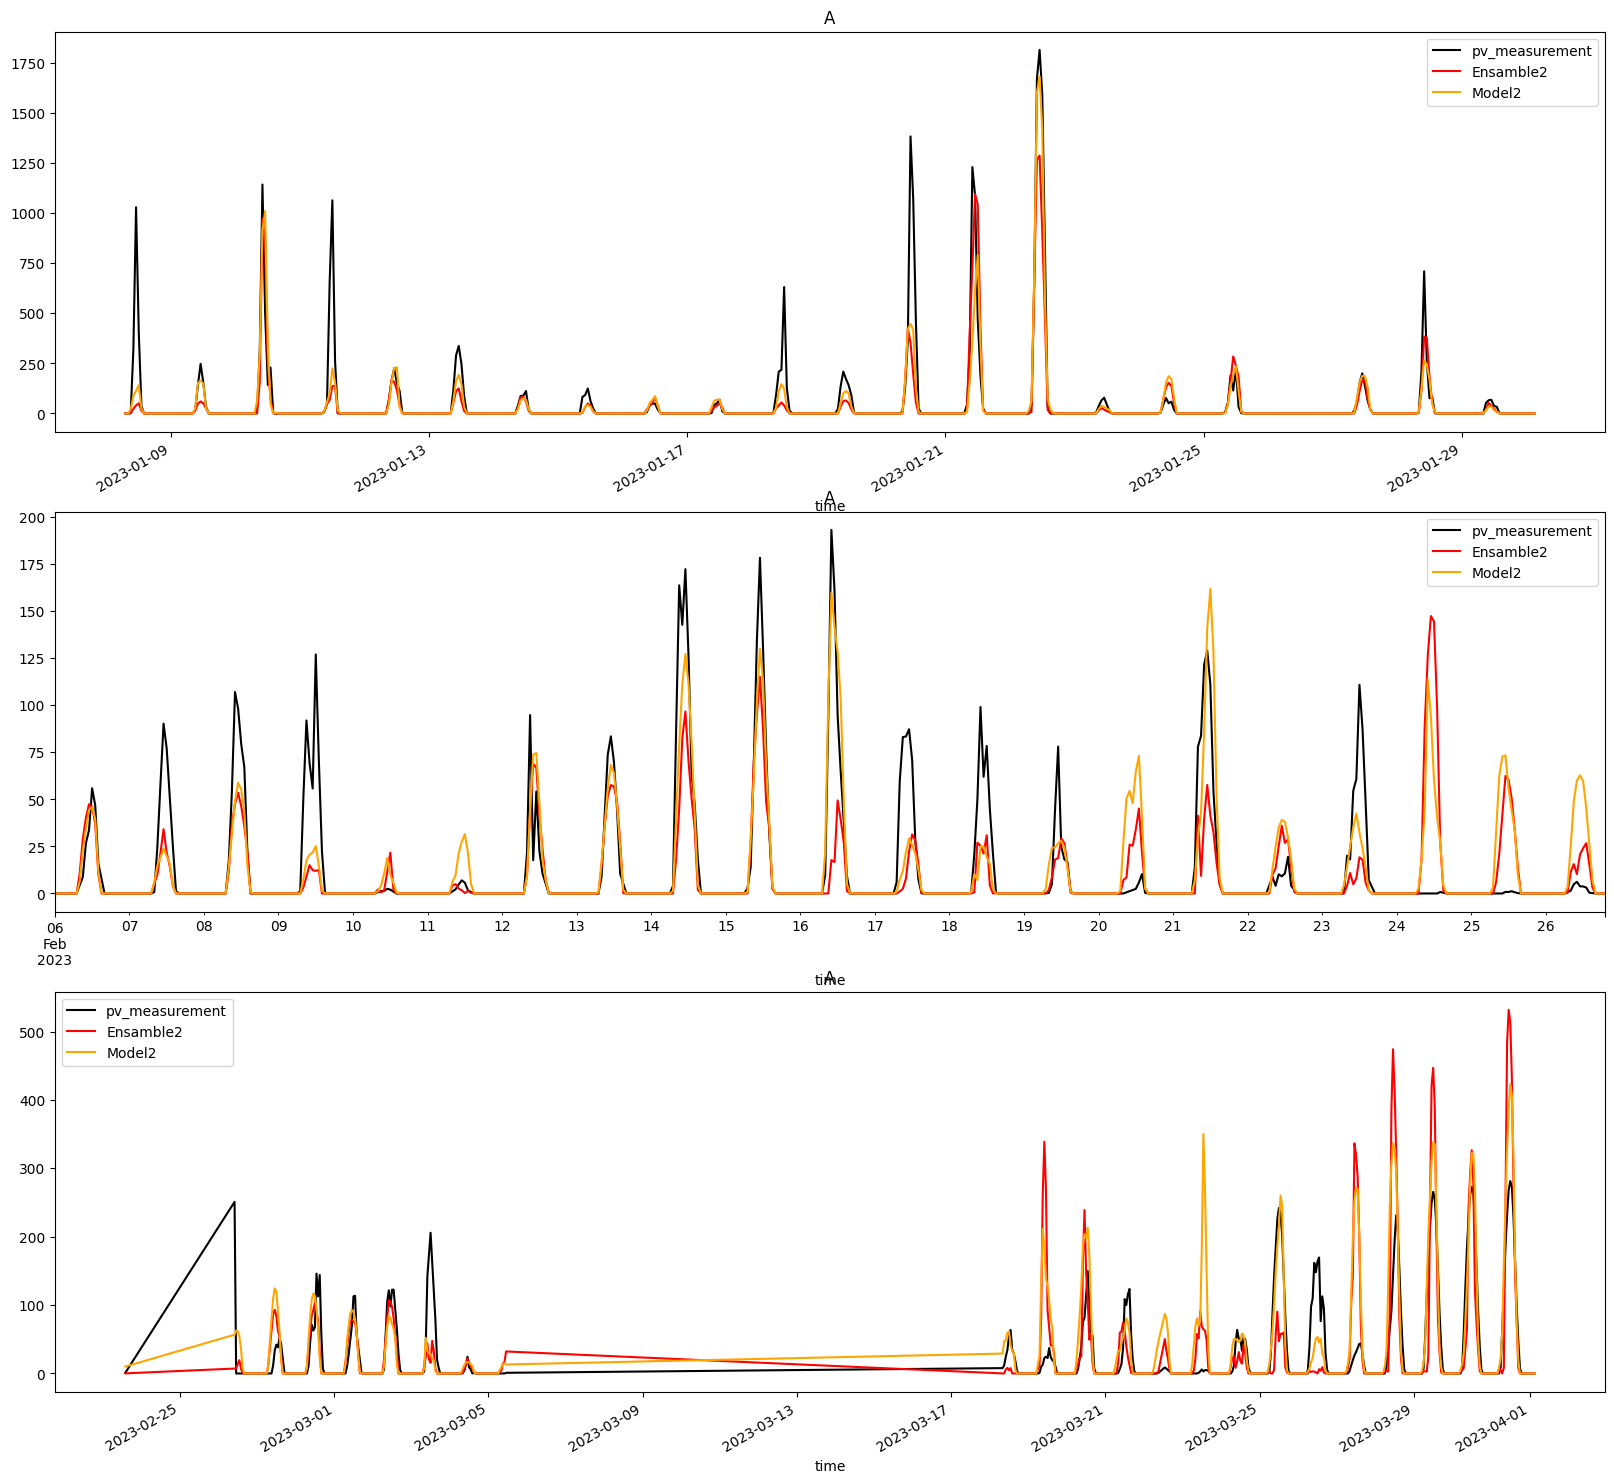

In [42]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20), sharex=False)


comparisonA.iloc[1000:1500][['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='A', color='black')
comparisonA.iloc[1000:1500][['time', "Ensamble2"]].set_index('time').plot(ax=axs[0], title='A', color='red')
comparisonA.iloc[1000:1500][['time', "Model2"]].set_index('time').plot(ax=axs[0], title='A', color='orange')
comparisonB.iloc[1000:1500][['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='A', color='black')
comparisonB.iloc[1000:1500][['time', "Ensamble2"]].set_index('time').plot(ax=axs[1], title='A', color='red')
comparisonB.iloc[1000:1500][['time', "Model2"]].set_index('time').plot(ax=axs[1], title='A', color='orange')
comparisonC.iloc[1000:1500][['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='A', color='black')
comparisonC.iloc[1000:1500][['time', "Ensamble2"]].set_index('time').plot(ax=axs[2], title='A', color='red')
comparisonC.iloc[1000:1500][['time', "Model2"]].set_index('time').plot(ax=axs[2], title='A', color='orange')
